In [1]:
import geopandas
import pydeck
import numpy as np

In [3]:
# cqi = Cycling Quality Index, data here based on a overpass turbo query and a py script made by osm-verkehrswende.org
cqi_data = geopandas.read_file('cycling_quality_index.geojson')

In [4]:
# this is the overpass export from Relation: Rad-Hauptroute (3641049) https://www.openstreetmap.org/relation/3641049
bikeroutes_data = geopandas.read_file('Hauptrouten_osm_export.geojson')

In [5]:
bikeroutes_data.head(3)

,id,@id,access,access:lanes,access:lanes:forward,agricultural,alt_name,bicycle,bicycle:backward,bicycle:conditional,...,website,wheelchair,width,width:available,width:lanes,wikidata,wikipedia,zone:maxspeed,zone:traffic,geometry
0,way/3999478,way/3999478,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,de:Lilienthaler Heerstraße,None,None,"LINESTRING (8.88057 53.10163, 8.88063 53.10166..."
1,way/3999570,way/3999570,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (8.90266 53.10012, 8.90316 53.09982..."
2,way/3999576,way/3999576,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (8.87184 53.09713, 8.87151 53.09714..."


In [6]:
cqi_data.head(3)

,id,name,way_type,index,index_10,stress_level,offset,side,proc_width,proc_surface,...,data_missing,data_missing_width,data_missing_surface,data_missing_smoothness,data_missing_maxspeed,data_missing_parking,data_missing_lit,filter_usable,filter_way_type,geometry
0,way/3999478,Lilienthaler Heerstraße,shared traffic lane,29,2,4,NaN,None,3.2,asphalt,...,width:lanes,NaN,NaN,NaN,NaN,NaN,NaN,1,shared traffic,"LINESTRING (8.88057 53.10163, 8.88070 53.10168)"
1,way/3999570,Rockwinkeler Heerstraße,shared traffic lane,29,2,4,NaN,None,3.2,asphalt,...,width:lanes;smoothness,NaN,NaN,1.0,NaN,NaN,NaN,1,shared traffic,"LINESTRING (8.90266 53.10012, 8.90316 53.09982..."
2,way/3999575,Luisental,shared road,63,6,2,NaN,None,11.0,asphalt,...,width;smoothness;lit,1.0,NaN,1.0,NaN,NaN,1.0,1,shared traffic,"LINESTRING (8.87138 53.09840, 8.87188 53.09836..."


In [7]:
# checking the coordinate reference system (crs)
print(f'cqi_data crs: {cqi_data.crs}')
print(f'bikeroutes_data crs: {bikeroutes_data.crs}')

cqi_data crs: EPSG:4326
bikeroutes_data crs: EPSG:4326


In [8]:
# reading data from file takes a while so the raw data is copied in a new var for safety
df_cqi = cqi_data
df_bikeroutes = bikeroutes_data

In [9]:
# create a list with the OSM way IDs of the Hauptrouten 
filter_list  = df_bikeroutes['id'].to_list()

In [10]:
# count way in Hauptrouten
len(filter_list)

4348

In [11]:
# filter CQI data based on way IDs of the Hauptrouten
df_final = df_cqi[df_cqi['id'].isin(filter_list)]

In [12]:
# ways in filtered dataframe
# it's different
len(df_final)

6415

In [13]:
# let's check if there are duplicated IDs in dataframe
df = df_final

print(df[df.duplicated(subset='id')])

                   id                    name        way_type  index  \
31874     way/4672616    Heinrich-Plett-Allee     cycle track     53   
31876   way/140686318       Stader Landstraße     cycle track     56   
31877   way/188411413            Contrescarpe     cycle track     57   
31879   way/851623150           Farger Straße     cycle track     53   
31880   way/140648423       Burger Heerstraße     cycle track     64   
...               ...                     ...             ...    ...   
35476    way/31014131            Achterstraße  shared footway     44   
35477  way/1248915807          Rekumer Straße  shared footway     44   
35478    way/27800973          Rekumer Straße  shared footway     44   
35479   way/280412362      Borchshöher Straße  shared footway     37   
35480   way/115412890  Zum Huchtinger Bahnhof  shared footway     44   

       index_10  stress_level  offset   side  proc_width   proc_surface  ...  \
31874         5             1     0.0   left         1.

In [15]:
# the is still a difference between CQI data without duplicated IDs and IDs in Hauptrouten
len(df) - len(df[df.duplicated(subset='id')])

4173

In [16]:
# it seems the osm-verkehrwende py script splits some ways in three (see column 'side') None, left and right
df[df['id'] == 'way/140648423']

,id,name,way_type,index,index_10,stress_level,offset,side,proc_width,proc_surface,...,data_missing,data_missing_width,data_missing_surface,data_missing_smoothness,data_missing_maxspeed,data_missing_parking,data_missing_lit,filter_usable,filter_way_type,geometry
12666,way/140648423,Burger Heerstraße,shared traffic lane,29,2,4,NaN,None,3.2,asphalt,...,width:lanes;smoothness,NaN,NaN,1.0,NaN,NaN,NaN,1,shared traffic,"LINESTRING (8.70431 53.15652, 8.70417 53.15718)"
31880,way/140648423,Burger Heerstraße,cycle track,64,6,1,0.0,left,1.5,concrete,...,width,1.0,NaN,NaN,NaN,NaN,NaN,1,separated,"LINESTRING (8.70431 53.15652, 8.70417 53.15718)"
34118,way/140648423,Burger Heerstraße,cycle track,64,6,1,0.0,right,1.5,concrete,...,width,1.0,NaN,NaN,NaN,NaN,NaN,1,separated,"LINESTRING (8.70431 53.15652, 8.70417 53.15718)"


In [17]:
# another test
df[df['id'] == 'way/4672616']

,id,name,way_type,index,index_10,stress_level,offset,side,proc_width,proc_surface,...,data_missing,data_missing_width,data_missing_surface,data_missing_smoothness,data_missing_maxspeed,data_missing_parking,data_missing_lit,filter_usable,filter_way_type,geometry
1285,way/4672616,Heinrich-Plett-Allee,shared traffic lane,29,2,4,NaN,None,3.2,asphalt,...,width:lanes;smoothness,NaN,NaN,1.0,NaN,NaN,NaN,1,shared traffic,"LINESTRING (8.71548 53.05328, 8.71542 53.05298..."
31874,way/4672616,Heinrich-Plett-Allee,cycle track,53,5,1,0.0,left,1.5,paving_stones,...,width;surface;smoothness,1.0,1.0,1.0,NaN,NaN,NaN,1,separated,"LINESTRING (8.71548 53.05328, 8.71542 53.05298..."
34106,way/4672616,Heinrich-Plett-Allee,cycle track,53,5,1,0.0,right,1.5,paving_stones,...,width;surface;smoothness,1.0,1.0,1.0,NaN,NaN,NaN,1,separated,"LINESTRING (8.71548 53.05328, 8.71542 53.05298..."


In [18]:
# transform geometry to a list with lat,lon
# https://stackoverflow.com/questions/69305911/plot-linestring-z-from-geodataframe-using-pydecks-pathlayer-or-triplayer
def my_geom_coord_extractor(input_geom):
    if (input_geom is None) or (input_geom is np.nan):
        return []
    else:
        if input_geom.type[:len('multi')].lower() == 'multi':
            full_coord_list = []
            for geom_part in input_geom.geoms:
                geom_part_2d_coords = [[coord[0],coord[1]] for coord in list(geom_part.coords)]
                full_coord_list.append(geom_part_2d_coords)
        else:
            full_coord_list = [[coord[0],coord[1]] for coord in list(input_geom.coords)]
        return full_coord_list

In [19]:
# let's plot a map for more visual exploration


# set a manual filter for dataframe
df = df_final
#df = df_final[df_final['filter_usable'] == 1]


df['coord_list'] = df['geometry'].apply(my_geom_coord_extractor)




view = pydeck.ViewState(latitude=53.075709, longitude=8.803960)
#view.pitch = 55
view.bearing = 60
view.zoom = 13
view.height = 800


cqi_br = pydeck.Layer(
    type='PathLayer',
    data=df,
    pickable=True,
    get_color='[126, index*2.5, index*1.25, 155]',
    width_scale=5,
    width_min_pixels=2,
    get_path='coord_list',
    get_width=1,
)



map= pydeck.Deck(layers=[cqi_br],
        initial_view_state=view,
        map_style='light'
        )
map.show()

C:\Users\koma2\AppData\Local\Temp\ipykernel_9696\193320771.py:7: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if input_geom.type[:len('multi')].lower() == 'multi':
c:\Users\koma2\anaconda3\envs\unfallatlas\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{\n  "initialViewState": {…

In [20]:
df_final.columns

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'geometry', 'coord_list'],
      dtype='object')

In [21]:
# Mittelwert Qualitätsindex
df_final['index'].mean()

46.59204988308652

In [22]:
# Mittelwert Qualitätsindex bei Filter nach Nutzbarkeit
df_final[df_final['filter_usable'] == 1]['index'].mean()

46.8497772119669

<Axes: xlabel='proc_surface'>

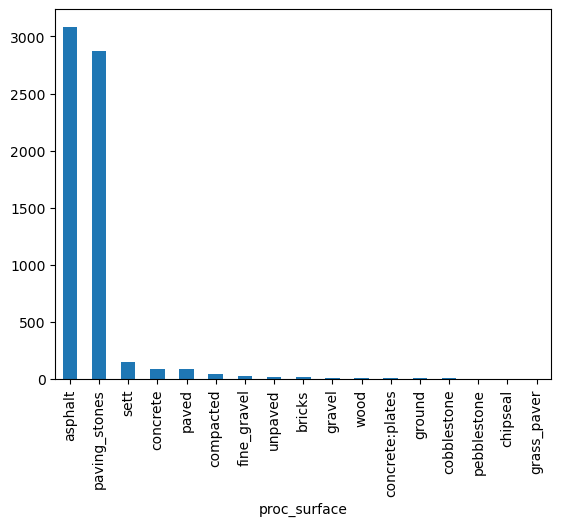

In [23]:
# Anzahl der Wege nach Oberflächenmaterial
df_final['proc_surface'].value_counts().plot(kind='bar')

<Axes: xlabel='proc_maxspeed'>

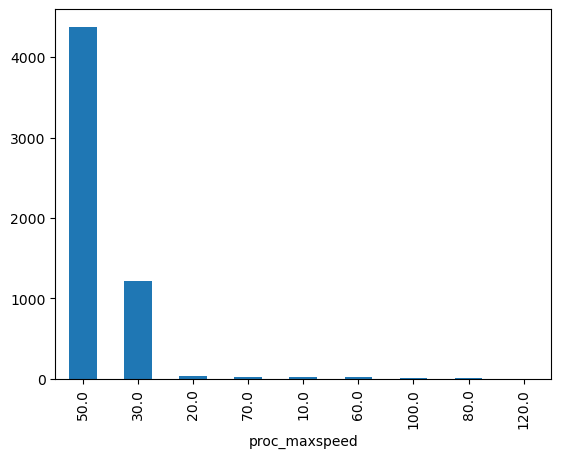

In [24]:
# Anzahl der Wege nach Geschwindigkeitsbegrenzung
df_final['proc_maxspeed'].value_counts().plot(kind='bar')

<Axes: xlabel='proc_smoothness'>

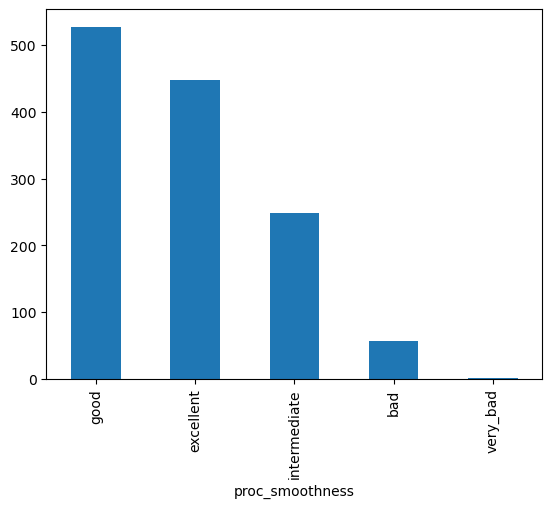

In [25]:
# Anzahl der Wege nach Oberflächenbeschaffenheit
df_final['proc_smoothness'].value_counts().plot(kind='bar')

In [26]:
# calc lenght of epsg 4326 linestrings
# https://stackoverflow.com/questions/71412258/calculate-length-of-linestring-in-meters-using-python

from pyproj import Transformer
from shapely.geometry import LineString
import shapely.ops as sp_ops

latlon = [[59.94661244955431, 10.72052329576658], [59.948009419166226, 10.725362000881619]]
xy = [(lon, lat) for lat, lon in latlon]
line = LineString(xy)
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:32632', always_xy=True)
line_transformed = sp_ops.transform(transformer.transform, line)
line_transformed.length


311.9284270277389

In [27]:
line = df_final.geometry[0]

def way_lenght(geometry):
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:32632', always_xy=True)
    line_transformed = sp_ops.transform(transformer.transform, geometry)
    return line_transformed.length


In [28]:
df = df_final

for i in df.index:
    geo = df.at[i, 'geometry']
    df.at[i, 'way_lenght'] = way_lenght(geo)

c:\Users\koma2\anaconda3\envs\unfallatlas\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [29]:
df.way_lenght.sum()

879298.7068495062

In [30]:
df.way_lenght.sum() / 1000

879.2987068495063

# Stats of Hauptrouten

In [31]:
df = df_bikeroutes

In [32]:
# filter some cols
df =df[['id', 'access', 'access:lanes', 'access:lanes:forward', 'bicycle', 'bicycle:backward',
 'bicycle:conditional', 'bicycle:forward', 'bicycle:lanes', 'bicycle:lanes:backward', 'bicycle:lanes:forward',
 'bicycle_road', 'bridge', 'bridge:name', 'bridge:ref', 'bridge:structure', 'bridleway',
 'change:lanes:backward', 'change:lanes:forward', 'check_date', 'check_date:bicycle', 'check_date:cycleway', 'check_date:footway:surface',
 'check_date:lit', 'check_date:segregated', 'check_date:smoothness', 'check_date:surface', 'check_date:tracktype', 'crossing',
 'crossing:island', 'cycleway', 'cycleway:bicycle', 'cycleway:both', 'cycleway:both:bicycle', 'cycleway:both:colour',
 'cycleway:both:lane', 'cycleway:both:segregated', 'cycleway:both:smoothness', 'cycleway:both:surface', 'cycleway:both:traffic_sign', 'cycleway:both:width',
 'cycleway:colour', 'cycleway:crossing:markings', 'cycleway:freedom_of_choice', 'cycleway:lane', 'cycleway:lanes', 'cycleway:left',
 'cycleway:left:bicycle', 'cycleway:left:colour', 'cycleway:left:freedom_of_choice', 'cycleway:left:lane', 'cycleway:left:mandatory', 'cycleway:left:oneway',
 'cycleway:left:segregated', 'cycleway:left:smoothness', 'cycleway:left:surface', 'cycleway:left:traffic_sign', 'cycleway:left:traffic_sign:backward', 'cycleway:left:traffic_sign:forward',
 'cycleway:left:width', 'cycleway:note', 'cycleway:oneway', 'cycleway:right', 'cycleway:right:bicycle', 'cycleway:right:bicycle:backward',
 'cycleway:right:bicycle:forward', 'cycleway:right:colour', 'cycleway:right:freedom_of_choice', 'cycleway:right:lane', 'cycleway:right:mandatory', 'cycleway:right:mofa',
 'cycleway:right:oneway', 'cycleway:right:segregated', 'cycleway:right:smoothness', 'cycleway:right:surface', 'cycleway:right:surface:colour', 'cycleway:right:traffic_sign',
 'cycleway:right:traffic_sign:backward', 'cycleway:right:traffic_sign:forward', 'cycleway:right:width', 'cycleway:segregated', 'cycleway:smoothness', 'cycleway:surface',
 'cycleway:surface:both', 'cycleway:surface:colour', 'cycleway:traffic_sign', 'cycleway:width', 'foot', 'foot:lanes',
 'footway', 'footway:colour', 'footway:crossing:markings', 'footway:left', 'footway:right', 'footway:right:bicycle', 'footway:right:foot',
 'footway:right:oneway', 'footway:right:segregated', 'footway:right:smoothness', 'footway:right:surface', 'footway:right:traffic_sign', 'footway:smoothness',
 'footway:surface', 'footway:surface:description', 'footway:width', 'lanes', 'maxspeed', 'motor_vehicle', 'motor_vehicle:lanes',
 'motorcar', 'motorcycle', 'motorroad', 'name', 'note:cycleway', 'note:oneway:bicycle', 'note:segregated',
 'oneway', 'oneway:bicycle', 'oneway:bus', 'segregated', 'service', 'sidewalk', 'sidewalk:bicycle', 'sidewalk:both',
 'sidewalk:both:bicycle', 'sidewalk:both:bicycle:signed', 'sidewalk:both:handrail', 'sidewalk:both:smoothness', 'sidewalk:both:surface',
 'sidewalk:both:traffic_sign', 'sidewalk:left', 'sidewalk:left:bicycle', 'sidewalk:left:oneway', 'sidewalk:left:surface', 'sidewalk:left:traffic_sign',
 'sidewalk:left:width', 'sidewalk:right', 'sidewalk:right:bicycle', 'sidewalk:right:bicycle:signed', 'sidewalk:right:foot',
 'sidewalk:right:oneway', 'sidewalk:right:segregated', 'sidewalk:right:smoothness', 'sidewalk:right:surface', 'sidewalk:right:traffic_sign',
 'sidewalk:traffic_sign', 'smoothness', 'surface', 'zone:maxspeed', 'zone:traffic', 'geometry']]

In [33]:
df['coord_list'] = df['geometry'].apply(my_geom_coord_extractor)

C:\Users\koma2\AppData\Local\Temp\ipykernel_9696\193320771.py:7: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if input_geom.type[:len('multi')].lower() == 'multi':
c:\Users\koma2\anaconda3\envs\unfallatlas\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [34]:
len(df)

4348

In [35]:
df_missing = geopandas.GeoDataFrame(df.isna().sum())

In [44]:
df_missing[df_missing[0] == 0]

,0,percent1,percent2
id,0,0.0,0.0
geometry,0,0.0,0.0
coord_list,0,0.0,0.0


In [36]:
# dropping all cols  with zero missing data
df_missing[df_missing[0] != 0]

,0
access,4331
access:lanes,4343
access:lanes:forward,4346
bicycle,2625
bicycle:backward,4344
...,...
sidewalk:traffic_sign,4345
smoothness,3227
surface,166
zone:maxspeed,4323


In [37]:
df_missing['percent1'] = df_missing[0] / len(df)

In [38]:
df_missing['percent2'] = df_missing['percent1'] * 100

In [39]:
df_missing[df_missing['percent2'] <= 70] 

,0,percent1,percent2
id,0,0.000000,0.000000
bicycle,2625,0.603726,60.372585
foot,2765,0.635925,63.592456
lanes,2874,0.660994,66.099356
maxspeed,1847,0.424793,42.479301
name,1364,0.313707,31.370745
oneway,2295,0.527829,52.782889
sidewalk,2438,0.560718,56.071757
surface,166,0.038178,3.817847
geometry,0,0.000000,0.000000


<Axes: xlabel='maxspeed'>

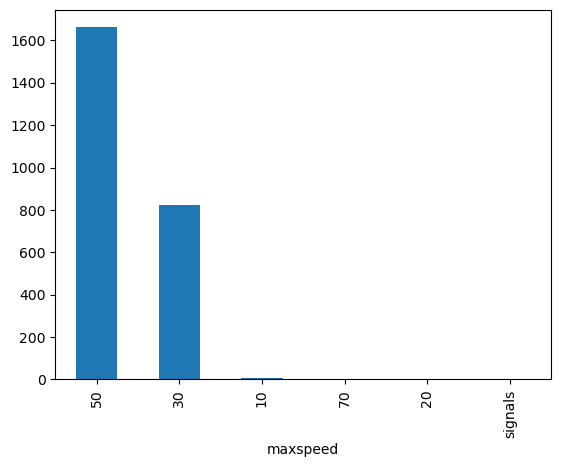

In [40]:
df['maxspeed'].value_counts().plot(kind='bar')

<Axes: xlabel='bicycle'>

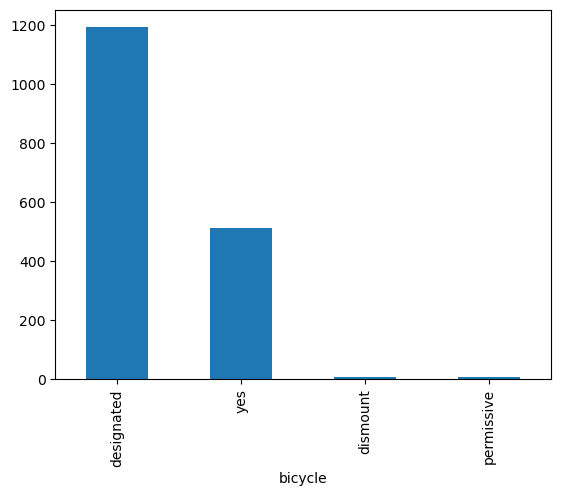

In [41]:
df['bicycle'].value_counts().plot(kind='bar')

In [42]:
df_dismount = df[df['bicycle'] ==  'dismount']

view = pydeck.ViewState(latitude=53.075709, longitude=8.803960)
#view.pitch = 55
view.bearing = 60
view.zoom = 13
view.height = 800


cqi_br = pydeck.Layer(
    type='PathLayer',
    data=df_dismount,
    pickable=True,
    get_color='[126, index*2.5, index*1.25, 155]',
    width_scale=5,
    width_min_pixels=2,
    get_path='coord_list',
    get_width=1,
)

map= pydeck.Deck(layers=[cqi_br],
        initial_view_state=view,
        map_style='light'
        )
map.show()

DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{\n  "initialViewState": {…

In [43]:
df_dismount

,id,access,access:lanes,access:lanes:forward,bicycle,bicycle:backward,bicycle:conditional,bicycle:forward,bicycle:lanes,bicycle:lanes:backward,...,sidewalk:right:smoothness,sidewalk:right:surface,sidewalk:right:traffic_sign,sidewalk:traffic_sign,smoothness,surface,zone:maxspeed,zone:traffic,geometry,coord_list
86,way/4282687,None,None,None,dismount,None,None,None,None,None,...,None,None,None,None,None,paving_stones,None,None,"LINESTRING (8.81122 53.07694, 8.81161 53.07709...","[[8.8112181, 53.0769383], [8.8116118, 53.07708..."
548,way/23339716,None,None,None,dismount,None,None,None,None,None,...,None,None,None,None,None,metal,None,None,"LINESTRING (8.62544 53.16806, 8.62497 53.16836)","[[8.6254369, 53.1680634], [8.6249657, 53.16835..."
652,way/23970461,None,None,None,dismount,None,None,None,None,None,...,None,None,None,None,None,metal,None,None,"LINESTRING (8.62497 53.16836, 8.62494 53.16837)","[[8.6249657, 53.1683557], [8.6249401, 53.16837..."
793,way/26644111,None,None,None,dismount,None,None,None,None,None,...,None,None,None,None,good,asphalt,None,None,"LINESTRING (8.68813 53.17053, 8.68797 53.17059...","[[8.6881343, 53.1705324], [8.6879684, 53.17059..."
1714,way/188806173,None,None,None,dismount,None,None,None,None,None,...,None,None,None,None,None,paving_stones,None,None,"LINESTRING (8.81115 53.07691, 8.81122 53.07694)","[[8.8111484, 53.0769123], [8.8112181, 53.07693..."
2397,way/250182712,None,None,None,dismount,None,None,None,None,None,...,None,None,None,None,excellent,paving_stones,None,None,"LINESTRING (8.81068 53.07672, 8.81075 53.07674...","[[8.8106798, 53.0767243], [8.8107539, 53.07673..."
3377,way/525700454,None,None,None,dismount,None,None,None,None,None,...,None,None,None,None,None,metal,None,None,"LINESTRING (8.62544 53.16806, 8.62563 53.16795)","[[8.6254369, 53.1680634], [8.6256261, 53.16794..."
4149,way/1167751343,None,None,None,dismount,None,None,None,None,None,...,None,None,None,None,good,paving_stones,None,None,"LINESTRING (8.68816 53.17011, 8.68813 53.17053)","[[8.6881648, 53.1701078], [8.6881343, 53.17053..."
4168,way/1180170899,None,None,None,dismount,None,None,None,None,None,...,None,None,None,None,None,paving_stones,None,None,"LINESTRING (8.58467 53.18690, 8.58464 53.18695...","[[8.5846668, 53.1869044], [8.5846429, 53.18694..."


<Axes: xlabel='cycleway'>

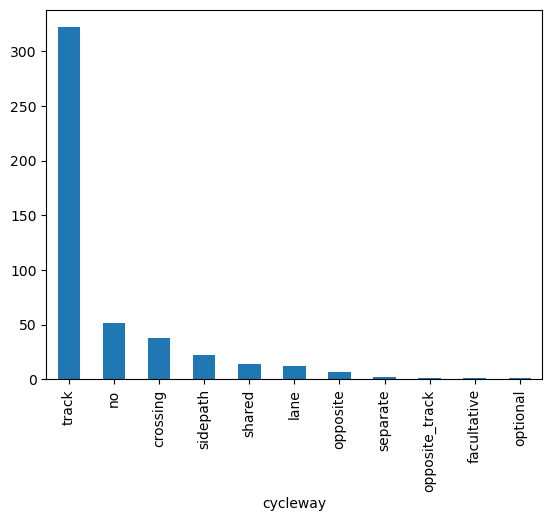

In [48]:
df['cycleway'].value_counts().plot(kind='bar')

<Axes: xlabel='smoothness'>

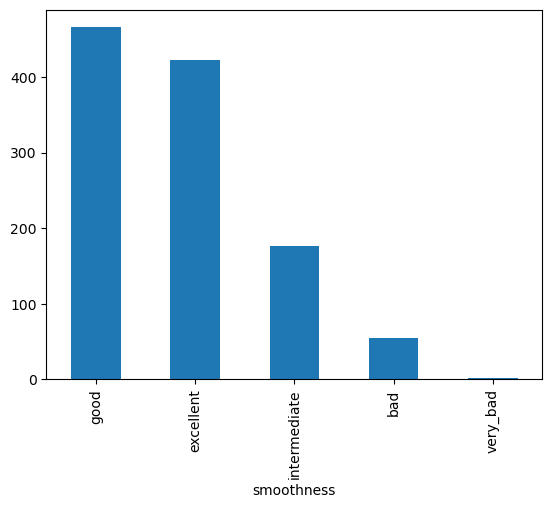

In [49]:
df['smoothness'].value_counts().plot(kind='bar')